# CESM2-Large Ensemble Reproduction of Kay et al. 2015

## Imports

In [ ]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# Silence dask.distributed logs
import logging

logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

import intake
import numpy as np
import pandas as pd
import xarray as xr
from ncar_jobqueue import NCARCluster
from distributed import Client


## Spin up a Cluster

In [ ]:
cluster = NCARCluster(memory='20 GB')
cluster.scale(20)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/45924/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/45924/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:39807,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/45924/status,Total threads: 0
Started: 2 minutes ago,Total memory: 0 B


## Read in Data

### Access the Grid Data

In [ ]:
grid_ds = xr.open_dataset('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/C_AREA/b.e21.BHISTsmbb.f09_g17.LE2-1251.020.cam.h0.AREA.185001-201412.nc')

In [ ]:
area = grid_ds.isel(time=0).AREA

### Use the `Intake-ESM` Catalog to Access the Data

In [ ]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

### Subset for Daily Temperature Data (`TREFHT`)

In [ ]:
catalog_subset = catalog.search(variable='TREFHT', frequency='day_1')

In [9]:
catalog_subset.groupby_attrs = ['component',
                                'experiment',
                                'stream',
                                'forcing_variant',
                                'variable']

In [10]:
dsets = catalog_subset.to_dataset_dict(cdf_kwargs={'chunks':{'time':365}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


In [251]:
historical = dsets['atm.historical.cam.h0.cmip6.TREFHT']

In [252]:
future = dsets['atm.ssp370.cam.h0.cmip6.TREFHT']

In [253]:
merge_ds = xr.concat([historical, future], dim='time')

In [254]:
t_ref = merge_ds[['TREFHT']]

In [255]:
areacella = area

In [256]:
total_area = areacella.sum()

In [257]:
t_ref

,Array,Chunk
Bytes,31.02 GiB,12.66 MiB
Shape,"(50, 3012, 192, 288)","(1, 60, 192, 288)"
Count,17669 Tasks,2550 Chunks
Type,float32,numpy.ndarray


In [106]:
from datetime import timedelta

In [258]:
t_ref_ts = (
    (t_ref.resample(time="AS").mean("time") * areacella).sum(dim=("lat", "lon"))
    / total_area
)

In [259]:
ds = t_ref_ts.compute()

In [ ]:
ds['time'] = t_ref_ts.indexes['time'].to_datetimeindex()


In [260]:
ds['time'] = ds.indexes['time'].to_datetimeindex() + timedelta(days=14)

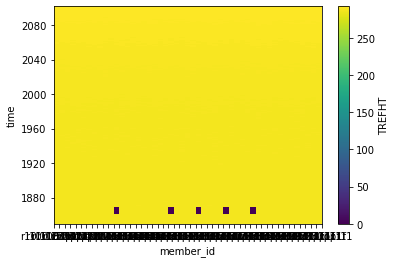

In [261]:
ds.TREFHT.plot()

In [262]:
df = ds.TREFHT.to_dataframe()
unstack = df.unstack(level=1).TREFHT

In [263]:
bad_members = []
for member_id in unstack.columns:
    min_val = unstack[member_id].min()
    if min_val < 200:
        bad_members.append(member_id)
        print(member_id)

r2i1231p1f1
r4i1231p1f1
r5i1231p1f1
r6i1231p1f1
r7i1231p1f1


In [272]:
test_file = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.BHISTcmip6.f09_g17.LE2-1231.002.cam.h0.TREFHT.186001-186912.nc'

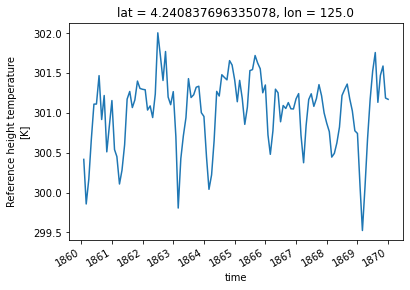

In [273]:
ds_test = xr.open_dataset(test_file)
ds_test['time'] = ds_test.indexes['time'].to_datetimeindex()
ds_test.TREFHT.isel(lat=100, lon=100).plot()

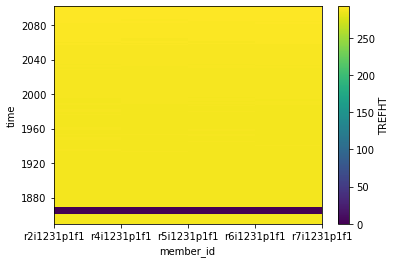

In [264]:
ds.sel(member_id=bad_members).TREFHT.plot()

In [244]:
ds.TREFHT.to_dataframe(dim_order=['time', 'member_id'])

TREFHT
time       member_id               
1850-01-15 r11i1231p1f2  287.434052
           r11i1251p1f2  287.559631
           r11i1281p1f2  287.239258
           r11i1301p1f2  287.150116
           r12i1231p1f2  287.367767
...                             ...
2101-01-15 r19i1301p1f2  290.772797
           r20i1231p1f2  290.707520
           r20i1251p1f2  290.803741
           r20i1281p1f2  290.808105
           r20i1301p1f2  290.787598

[10080 rows x 1 columns]

<AxesSubplot:xlabel='time'>

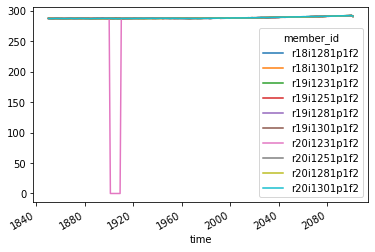

In [247]:
unstack[unstack.columns[30:40]].plot()

In [152]:
catalog_subset.df.

,component,stream,case,member_id,experiment,forcing_variant,control_branch_year,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment_id
0,atm,cam.h1,b.e21.BHISTsmbb.f09_g17.LE2-1301,r19i1301p1f2,historical,smbb,1301,TREFHT,1970-01-01,1979-12-31,19700101-19791231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r19i1301p1f2
1,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1231,r3i1231p1f1,historical,cmip6,1231,TREFHT,1930-01-01,1939-12-31,19300101-19391231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r3i1231p1f1
2,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1181,r10i1181p1f1,historical,cmip6,1181,TREFHT,1890-01-01,1899-12-31,18900101-18991231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r10i1181p1f1
3,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1231,r8i1231p1f1,historical,cmip6,1231,TREFHT,2000-01-01,2009-12-31,20000101-20091231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r8i1231p1f1
4,atm,cam.h1,b.e21.BHISTsmbb.f09_g17.LE2-1231,r18i1231p1f2,historical,smbb,1231,TREFHT,1870-01-01,1879-12-31,18700101-18791231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r18i1231p1f2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1121,r7i1121p1f1,historical,cmip6,1121,TREFHT,2000-01-01,2009-12-31,20000101-20091231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r7i1121p1f1
2323,atm,cam.h1,b.e21.BSSP370cmip6.f09_g17.LE2-1281,r10i1281p1f1,ssp370,cmip6,1281,TREFHT,2075-01-01,2084-12-31,20750101-20841231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_ssp370_r10i1281p1f1
2324,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1281,r8i1281p1f1,historical,cmip6,1281,TREFHT,1950-01-01,1959-12-31,19500101-19591231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r8i1281p1f1
2325,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1161,r9i1161p1f1,historical,cmip6,1161,TREFHT,1880-01-01,1889-12-31,18800101-18891231,Reference height temperature,K,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,CESM2_historical_r9i1161p1f1


In [161]:
catalog_subset.df[(catalog_subset.df.member_id == 'r20i1231p1f2') & 
                  (catalog_subset.df.experiment == 'historical')].start_time.unique()

array(['1880-01-01', '2010-01-01', '1970-01-01', '1940-01-01',
       '1930-01-01', '1850-01-01', '1980-01-01', '1910-01-01',
       '1960-01-01', '1860-01-01', '2000-01-01', '1990-01-01',
       '1950-01-01', '1870-01-01', '1890-01-01', '1920-01-01'],
      dtype=object)

In [179]:
t_ref['time'] = t_ref.indexes['time'].to_datetimeindex() + timedelta(hours=12)

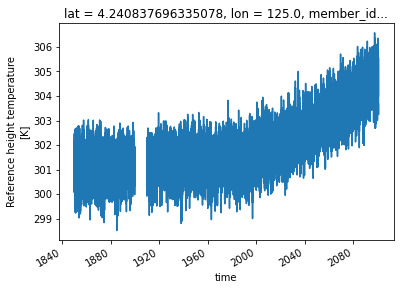

In [184]:
t_ref.sel(member_id = 'r20i1231p1f2').isel(lat=100, lon=100).TREFHT.plot()

In [194]:
bad_members

['r11i1251p1f2',
 'r12i1251p1f2',
 'r13i1251p1f2',
 'r16i1251p1f2',
 'r17i1251p1f2',
 'r18i1251p1f2',
 'r20i1231p1f2']

In [203]:
import glob

In [230]:
sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f09_g17.LE2-1251.011.cam.h1.TREFHT*'))

['/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f09_g17.LE2-1251.011.cam.h1.TREFHT.18500101-18591231.nc',
 '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f09_g17.LE2-1251.011.cam.h1.TREFHT.18600101-18691231.nc',
 '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f09_g17.LE2-1251.011.cam.h1.TREFHT.18700101-18791231.nc',
 '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f09_g17.LE2-1251.011.cam.h1.TREFHT.18800101-18891231.nc',
 '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f09_g17.LE2-1251.011.cam.h1.TREFHT.18900101-18991231.nc',
 '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f09_g17.LE2-1251.011.cam.h1.TREFHT.19100101-19191231.nc',
 '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TREFHT/b.e21.BHISTsmbb.f

In [ ]:
catalog_df.

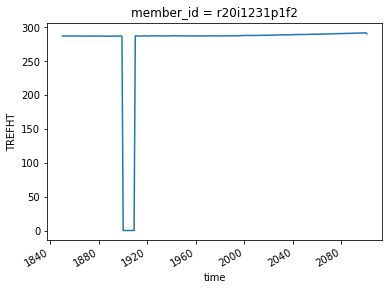

In [165]:
ds.sel(member_id='r20i1231p1f2').TREFHT.plot()

<AxesSubplot:xlabel='time'>

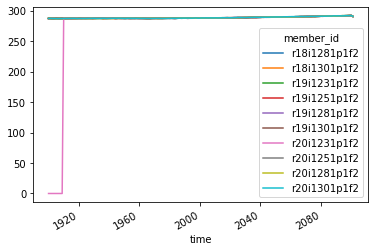

In [153]:
unstack[unstack.columns[30:40]].iloc[50:, :].plot()

<AxesSubplot:xlabel='time'>

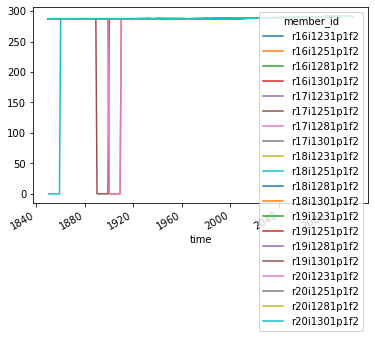

In [188]:
unstack[unstack.columns[20:40]].plot()

In [265]:
for index, row in unstack.iterrows():
    for member_id in bad_members:
        if row[member_id] < 200:
            print(index, member_id)

1861-01-15 00:00:00 r2i1231p1f1
1861-01-15 00:00:00 r4i1231p1f1
1861-01-15 00:00:00 r5i1231p1f1
1861-01-15 00:00:00 r6i1231p1f1
1861-01-15 00:00:00 r7i1231p1f1
1862-01-15 00:00:00 r2i1231p1f1
1862-01-15 00:00:00 r4i1231p1f1
1862-01-15 00:00:00 r5i1231p1f1
1862-01-15 00:00:00 r6i1231p1f1
1862-01-15 00:00:00 r7i1231p1f1
1863-01-15 00:00:00 r2i1231p1f1
1863-01-15 00:00:00 r4i1231p1f1
1863-01-15 00:00:00 r5i1231p1f1
1863-01-15 00:00:00 r6i1231p1f1
1863-01-15 00:00:00 r7i1231p1f1
1864-01-15 00:00:00 r2i1231p1f1
1864-01-15 00:00:00 r4i1231p1f1
1864-01-15 00:00:00 r5i1231p1f1
1864-01-15 00:00:00 r6i1231p1f1
1864-01-15 00:00:00 r7i1231p1f1
1865-01-15 00:00:00 r2i1231p1f1
1865-01-15 00:00:00 r4i1231p1f1
1865-01-15 00:00:00 r5i1231p1f1
1865-01-15 00:00:00 r6i1231p1f1
1865-01-15 00:00:00 r7i1231p1f1
1866-01-15 00:00:00 r2i1231p1f1
1866-01-15 00:00:00 r4i1231p1f1
1866-01-15 00:00:00 r5i1231p1f1
1866-01-15 00:00:00 r6i1231p1f1
1866-01-15 00:00:00 r7i1231p1f1
1867-01-15 00:00:00 r2i1231p1f1
1867-01-

In [219]:
for val in unstack['r11i1231p1f2']:
    print(val)

287.28875732421875
287.2091064453125
287.2934265136719
287.2645568847656
287.1981506347656
287.30841064453125
287.29864501953125
287.2839050292969
287.26153564453125
287.19500732421875
287.4273376464844
287.5030822753906
287.3841857910156
287.2043151855469
287.2713317871094
287.44378662109375
287.42724609375
287.3891906738281
287.5367736816406
287.3976135253906
287.4386901855469
287.4720764160156
287.4725036621094
287.3338928222656
287.49920654296875
287.421630859375
287.0423278808594
287.2106018066406
287.3175048828125
287.4079284667969
287.2562561035156
287.2859802246094
287.46636962890625
287.3858947753906
287.3060302734375
287.1737976074219
287.1665344238281
287.0654296875
287.11505126953125
287.1766052246094
287.0865173339844
286.997802734375
287.265869140625
287.2144470214844
287.0581359863281
287.1757507324219
287.0170593261719
287.0357971191406
287.1322021484375
287.2588806152344
287.1579284667969
287.375732421875
287.3969421386719
287.0652770996094
287.2508850097656
287.155242